## Назначение и цель проекта

Целью проекта является анализ тональности (настроения) отзывов пользователей о приложениях по тематике обучения (education) в магазине приложений AppStore.

## Выполнение проекта

### Сбор и сохранение данных для обучения и тестирования модели

Для сбора отзывов о приложениях (**100** различных) по тематике **education** будут использоваться следующие запросы к ресурсу [itunes.apple.com](https://apps.apple.com/us/genre/ios/id36):

- `https://itunes.apple.com/search?term=education&entity=software&limit=100` - поисковой запрос, который позволяет сформировать json-файл на основе параметров:
    - **entity** - вид медиа AppStore, например music или books (в данном проекте **software** - приложения);
    - **term** - тематика приложений (в данном проекте **education**);
    - **limit** - максимальное количество приложений, выдаваемых при запросе (в данном проекте **100**);


- `https://itunes.apple.com/us/rss/customerreviews/page={}/id={}/sortby=mostrecent/xml` - запрос, который позволяет сформировать xml-файл на основе параметров:
    - **page** - страница запроса (каждая страница содержит максимально 50 отзывов);
    - **id** - id приложения, отзывы которого необходимо загрузить;
    - **sortby** - сортировка для отзывов (в данном проекте **mostrecent** - самые последние).

#### Сбор данных о приложениях

Импортируем необходимые модули:

In [1]:
from json import loads              # для работы с json-файлами
from urllib.request import urlopen  # для открытия URL-адреса

Соберём данные (**ids** и **names**) о **100** различных приложениях по тематике **education**.

Для этого откроем URL-адрес `https://itunes.apple.com/search?term=education&entity=software&limit=100` с помощью функции `urlopen` модуля `urllib.request` и загрузим данные json-формата в переменную `apps_dict` c помощью функции `loads` модуля `json`:

In [2]:
source = 'https://itunes.apple.com/search?term=education&entity=software&limit=100'
with urlopen(source) as url:
    apps_dict = loads(url.read().decode())

В переменную `apps_dict` загрузится словарь вида:

```
{'resultCount': 5,
 'results': [{...}, ..., {...}]}
```

По ключу `results` станет доступен список из 100 словарей, каждый из которых содержит информацию о конкретном приложении. Информация об **id** и **name** для каждого приложения доступна по ключам `trackId` и `trackName` соответственно:

In [3]:
print(apps_dict['results'][0]['trackId'])    # информация об id первого приложения списка
print(apps_dict['results'][0]['trackName'])  # информация о title первого приложения списка

570060128
Duolingo - Language Lessons


Получим кортеж кортежей **ids** и **names** для каждого приложения:

In [4]:
apps = tuple((el['trackId'], el['trackName']) for el in apps_dict['results'])
print(apps[0])

(570060128, 'Duolingo - Language Lessons')


#### Создание датасетов для обучения модели и для проверки работы модели

Предварительно установим (если не установлены) необходимые модули в виртуальное окружение проекта, используя следующую команду:
```
pip3 install numpy pandas lxml langdetect spacy sklearn matplotlib
```

Импортируем необходимые модули:

In [5]:
import numpy as np
import pandas as pd

Сформируем на основе полученной информации два data frames, содержащие отзывы о приложениях:
- для обучения модели будет использоваться 2 страница (page=2) отзывов;
- для проверки модели будет использоваться 1 страница (page=1) отзывов

In [6]:
df = pd.DataFrame()        # инициализация DataFrame для обучения модели
df_check = pd.DataFrame()  # инициализация DataFrame для проверки модели

# цикл по 100 приложениям
for app_id, app_name in apps:
    
    # создание запросов с app_id
    url = f'https://itunes.apple.com/us/rss/customerreviews/page=2/id={app_id}/sortby=mostrecent/xml'
    url_check = f'https://itunes.apple.com/us/rss/customerreviews/page=1/id={app_id}/sortby=mostrecent/xml'
    
    # считывание xml-файла в Pandas DataFrame
    new_df = pd.read_xml(url, parser='lxml')  # lxml - требуемый парсер
    new_df_check = pd.read_xml(url_check, parser='lxml')
    
    # сохранение только нужных столбцов updated, content, rating
    cols = ['updated', 'content', 'rating']
    new_df = new_df.reindex(columns=cols)
    new_df_check = new_df_check.reindex(columns=cols)
    
    # и удалениe строк, в которых содержится общая информация 
    # о документе xml, а не сами обзоры (rating = NaN)
    new_df = new_df[new_df['rating'].notna()]
    new_df_check = new_df_check[new_df_check['rating'].notna()]
    
    # добавление столбца с именем приложения app_name
    new_df['app_name'] = app_name
    new_df_check['app_name'] = app_name
    
    # сохранение загруженных данных в общий DataFrame
    df = pd.concat([df, new_df], ignore_index=True)
    df_check = pd.concat([df_check, new_df_check], ignore_index=True)

In [7]:
df.head()

,updated,content,rating,app_name
0,2022-03-01T15:48:24-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",5.0,Duolingo - Language Lessons
1,2022-03-01T15:18:11-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",5.0,Duolingo - Language Lessons
2,2022-03-01T15:11:03-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",5.0,Duolingo - Language Lessons
3,2022-03-01T15:02:00-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",5.0,Duolingo - Language Lessons
4,2022-03-01T14:28:12-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",1.0,Duolingo - Language Lessons


#### Преобразование и очистка данных

В столбце **content** содержится текст отзыва, представленный частью html-документа:

In [8]:
text = df['content'][0]
text

'<table border="0" width="100%">\n    <tr>\n        <td>\n            <table border="0" width="100%" cellspacing="0" cellpadding="0">\n                <tr valign="top" align="left">\n                    \n                    \n                    \t<td width="100%">\n                    \n                        <b><a href="https://apps.apple.com/us/app/duolingo-language-lessons/id570060128?uo=2">Best language App!</a></b><br/>\n                        \n                        \n                        \n                        \n\n                        \n\n                       <font size="2" face="Helvetica,Arial,Geneva,Swiss,SunSans-Regular">\n\t\t\t\t\t\t\n                        </font>\n                    </td>\n                </tr>\n            </table>\n        </td>\n    </tr>\n    <tr>\n        <td>\n            \n                <font size="2" face="Helvetica,Arial,Geneva,Swiss,SunSans-Regular"><br/>It’s fun, interactive, and all around educational while learning more 

Для извлечения текстa из отзыва, необходимо обратиться к элементу по пути ***table -> tr -> td -> font -> текст***:
```
<table border="0" width="100%">
...
    <tr>
        <td>
            <font size="2" face="Helvetica,Arial,Geneva,Swiss,SunSans-Regular">
                <br/>It’s fun, interactive, and all around educational while learning more than expected! I start my day with my little green owl and add a lesson or two before heading to bed!
            </font><br/>
        </td>
    </tr>
</table>
```

Воспользуемся функцией `fromstring()` модуля `lxml.html`, которая преобразует входную строку в дерево элементов. Из полученного дерева с помощью метода `xpath` извлечем элементы `text()` и зпишем их в пременную `list_lxml`:

In [9]:
from lxml import html

# преобразование текста в дерево элементов
tree = html.fromstring(text)

# доступ к необходимым элементам через xpath
list_lxml = tree.xpath('//table/tr/td/font/text()')

list_lxml

['\n\t\t\t\t\t\t\n                        ',
 'It’s fun, interactive, and all around educational while learning more than expected! I start my day with my little green owl and add a lesson or two before heading to bed!']

Переменная `list_lxml` имеет тип `list` и содержит текстовые элементы, которые нам нужны. Первый элемент `\n\t\t\t\t\t\t\n` является лишним, поэтому им можно пренебречь. Из оставшихся элементов с помощью строкового метода `join()` будет создана одна строка с отзывом:

In [10]:
print(''.join(list_lxml[1:]))

It’s fun, interactive, and all around educational while learning more than expected! I start my day with my little green owl and add a lesson or two before heading to bed!


Для изменения всего столбца **content** создадим функцию, которая будет преобразовывать текст к нужной форме, и воспользуемся методом `apply` для применения этой функции к столбцу **content**:

In [11]:
def get_content(text):
    return ''.join(
        html.fromstring(text).xpath('//table/tr/td/font/text()')[1:]
    )

In [12]:
df['content'] = df['content'].apply(get_content)
df.head()

,updated,content,rating,app_name
0,2022-03-01T15:48:24-07:00,"It’s fun, interactive, and all around educatio...",5.0,Duolingo - Language Lessons
1,2022-03-01T15:18:11-07:00,"Because of Duolingo, I can speak simple senten...",5.0,Duolingo - Language Lessons
2,2022-03-01T15:11:03-07:00,Duolingo is s great if you have a short time t...,5.0,Duolingo - Language Lessons
3,2022-03-01T15:02:00-07:00,This app has carried my further than any of my...,5.0,Duolingo - Language Lessons
4,2022-03-01T14:28:12-07:00,Update it so you don’t have to sign in so you ...,1.0,Duolingo - Language Lessons


In [13]:
df_check['content'] = df_check['content'].apply(get_content)
df_check.head()

,updated,content,rating,app_name
0,2022-03-02T21:39:53-07:00,You cannot access your lessons offline.,1.0,Duolingo - Language Lessons
1,2022-03-02T20:30:33-07:00,So I was doing a lightning round and all it’s ...,1.0,Duolingo - Language Lessons
2,2022-03-02T19:48:02-07:00,Duolingo has helped me greatly improve my Span...,4.0,Duolingo - Language Lessons
3,2022-03-02T19:43:33-07:00,Given that I am I a fluent English speaker and...,1.0,Duolingo - Language Lessons
4,2022-03-02T19:41:53-07:00,It’s a clever well thought teaching app It tea...,5.0,Duolingo - Language Lessons


Проанализируем столбцы таблиц. Для этого воспользуемся методом `info()`:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   updated   4900 non-null   object 
 1   content   4900 non-null   object 
 2   rating    4900 non-null   float64
 3   app_name  4900 non-null   object 
dtypes: float64(1), object(3)
memory usage: 153.2+ KB


Информация о таблице показывает, что у нас нет столбцов, в которых бы содержались пустые значения. Значит таблице полная.

Просмотрим данные в столбце **content** для нахождения возможных некорректных значений (некоректными данными могут являться комментарии не на английском или небуквенные символы, относящиеся к смайлам или чему-либо еще).

In [16]:
text_not_en = df_check['content'][710]
text_not_en

'我希望同步的速度可以更快点，像聊天工具那样就好了'

In [17]:
text_smile = df['content'][35]
text_smile

'I learned Spanish within a week. Spanish or Vanish🤷🏻\u200d♀️'

Анализ столбца **content** показал, что иногда встречаются отзывы не на английском языке или отзывы, содержащие смайлики. Они могут помешать обучению, поэтому необходимо:
1. удалить отзывы не на английском языке;
1. удалить смайлы в отзывах.

Для удаления отзывов, написанных не на английском языке, воспользуемся функцией `detect` модуля `langdetect`:

In [18]:
from langdetect import detect

detect(text_not_en) == 'en'

False

Для удаления всех строк, содержащих отзывы не на английском языке создадим функцию, которая будет проверять язык текста, и воспользуемся методом apply для применения этой функции к столбцу **content** с последующей фильтрацией всей таблицы:

In [19]:
from langdetect import detect

def is_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False

In [20]:
print(df.shape[0])
print(df_check.shape[0])

4900
4919


In [21]:
df = df[df['content'].apply(is_en)]
df.shape[0]

4484

In [22]:
df_check = df_check[df_check['content'].apply(is_en)]
df_check.shape[0]

4492

Как видно выше, язык примерно 8% отзывов оказался не английским.

Для удаления смайлов в отзывах воспользуемся функцией `compile` модуля `re` для компиляции регулярного выражения, включающее возможные смайлики. Для применения регулярного выражения используем метод `replace`, который заменит все смайлы на пустые значения:

In [26]:
import re

# создание регулярного выражения со смайлами
emoticons_reg = re.compile("["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\U00002500-\U00002BEF"
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"
    u"\u3030"
    "]+", flags=re.UNICODE)

In [28]:
df['content'].replace(emoticons_reg, '', regex=True, inplace=True)
df_check['content'].replace(emoticons_reg, '', regex=True, inplace=True)
df['content'][35]

'I learned Spanish within a week. Spanish or Vanish'

Сохраним полученные таблицы:

In [53]:
# перестановка метами двух последних столбцов, чтобы rating оказался в самом конце
df = df[['updated', 'content', 'app_name', 'rating']]
df_check = df_check[['updated', 'content', 'app_name', 'rating']]

# преобразование типа столбца rating из float в integer
df['rating'] = pd.to_numeric(df['rating'], downcast='integer')
df_check['rating'] = pd.to_numeric(df_check['rating'], downcast='integer')

df.to_csv('datasets/train/reviews_train.csv', sep='|', index=False)
df_check.to_csv('datasets/check/reviews_check.csv', sep='|', index=False)

#### Анализ данных и подготовка данных к обучению

Загрузим данные из сохраненного csv-файла:

In [94]:
df = pd.read_csv('datasets/train/reviews_train.csv', sep='|')
df_check = pd.read_csv('datasets/check/reviews_check.csv', sep='|')
df.head()

,updated,content,app_name,rating
0,2022-03-01 15:48:24-07:00,"It’s fun, interactive, and all around educatio...",Duolingo - Language Lessons,5
1,2022-03-01 15:18:11-07:00,"Because of Duolingo, I can speak simple senten...",Duolingo - Language Lessons,5
2,2022-03-01 15:11:03-07:00,Duolingo is s great if you have a short time t...,Duolingo - Language Lessons,5
3,2022-03-01 15:02:00-07:00,This app has carried my further than any of my...,Duolingo - Language Lessons,5
4,2022-03-01 14:28:12-07:00,Update it so you don’t have to sign in so you ...,Duolingo - Language Lessons,1


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4484 entries, 0 to 4483
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   updated   4484 non-null   object
 1   content   4484 non-null   object
 2   app_name  4484 non-null   object
 3   rating    4484 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 140.2+ KB


Для обучения столбец **rating** является целевым признаком. Посмотрим на него подробнее с помощью графического представления, используя модуль `matplotlib.pyplot`:

In [69]:
import matplotlib.pyplot as plt

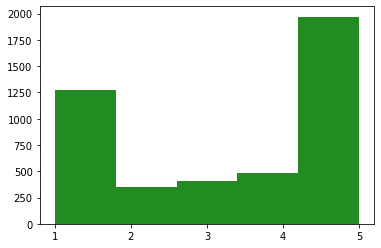

In [80]:
plt.hist(df['rating'], bins=5, color='forestgreen')
plt.xticks(np.arange(1, 6))
plt.show()

Чтобы обеспечить качество данных для последующего обучения, переведём столбец **rating** из 5-бальной шкалы в 2-бальную - "положительные" и "отрицательные" оценки. Это понадобится в последующем для модели обучения, а также поможет сравнять распределение классов целевого прзнака по количеству.

Примем за положительные оценки 5 и 4, а за отрицательные 3, 2 и 1. Для перевода столбца **rating** в 2-бальную шкалу воспользуемся функцией `where` библиотеки `numpy`, записав в неё соответствующее условие:

In [95]:
# условие:
# 5//2 = 2 > 1, 4//2 = 2 > 1
# 3//2 = 1 = 1, 2//2 = 1 = 1, 1//2 = 0 < 1
df['rating'] = np.where(df['rating'] // 2 > 1, 1, 0)
df_check['rating'] = np.where(df_check['rating'] // 2 > 1, 1, 0)
df.head()

,updated,content,app_name,rating
0,2022-03-01 15:48:24-07:00,"It’s fun, interactive, and all around educatio...",Duolingo - Language Lessons,1
1,2022-03-01 15:18:11-07:00,"Because of Duolingo, I can speak simple senten...",Duolingo - Language Lessons,1
2,2022-03-01 15:11:03-07:00,Duolingo is s great if you have a short time t...,Duolingo - Language Lessons,1
3,2022-03-01 15:02:00-07:00,This app has carried my further than any of my...,Duolingo - Language Lessons,1
4,2022-03-01 14:28:12-07:00,Update it so you don’t have to sign in so you ...,Duolingo - Language Lessons,0


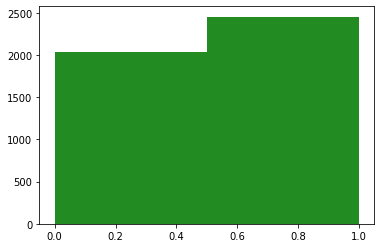

In [86]:
plt.hist(df['rating'], bins=2, color='forestgreen')
plt.show()

In [96]:
df.rating.value_counts()

1    2454
0    2030
Name: rating, dtype: int64

Удалим из таблицы лишнее количество строк с оценкой 1 (лишнее - разница между количеством оценок 1 и 0). Для этого воспользуемся функцией `choice` модуля `np.random`:

In [97]:
to_remove = np.random.choice(
    df[df['rating'] == 1].index,
    size=2454-2030,
    replace=False
)
to_remove.size

424

In [98]:
df = df.drop(to_remove)
df.rating.value_counts()[0]

2030

In [100]:
n = df_check.rating.value_counts()[1] - df_check.rating.value_counts()[0]
to_remove = np.random.choice(
    df_check[df_check['rating'] == 1].index,
    size=n,
    replace=False
)
df_check = df_check.drop(to_remove)
df_check.rating.value_counts()

0    2025
1    2025
Name: rating, dtype: int64

Сохраним полученные таблицы:

In [102]:
df.to_csv('datasets/train/final_reviews_train.csv', sep='|', index=False)
df_check.to_csv('datasets/check/final_reviews_check.csv', sep='|', index=False)